# Adaptive noise cancellation demo

 This notebook demonstrates adaptive noise cancellation (ANC) techniques for removing power line interference from signals.
 
 The demo shows how to:
 - Generate synthetic data with power line noise
 - Apply adaptive RLS filtering to cancel the noise
 - Evaluate the filtering performance
 
 The code implements the algorithm described in ["Adaptive cancellation of mains power interference in continuous gravitational wave searches with a hidden Markov model"](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.110.122004)

 ---
 


## 0. Setup 

In [1]:
# %%
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
sys.path.append('../python/')


## 1. Synthetic data 




In [3]:
import numpy as np 
from ANC.generate_synthetic_data import simulate_data
from ANC.hmm_viterbi import viterbi_for_ANC
from ANC.adaptive_filters import arls_n


# Generate simulated data
# The signal measured in the strain channel is x(t) = h(t) + c(t) + n(t)
# where h(t) is the GW signal, c(t) is the non-Gaussian interference, and n(t) is Gaussian noise.
# Separately, the reference signal is r(t) = A_ac * cos(2πf0t + θ(t)) + n_r(t)
# where A_ac is the amplitude of the reference signal, f0 is the central frequency, and θ(t) is the phase noise.
# See the paper for more details.

print("Generating simulated data")

## Sampling parameters 
W = 1000  # Sampling frequency
N = 2**14 # Number of samples per block
T = N/W   # Time within one block
Nb = 64  # Number of frequency blocks for simulated GW signal


## GW parameters 
sigma_f = 1  # Standard deviation of GW frequency
fq      = np.cumsum(np.concatenate(([59.5], sigma_f * np.sqrt(T) * np.random.randn(Nb-1)))) #array of random GW frequencies, see Equation 20 and 21 in paper. Note that the frequency updates are happing at the block level rather than every sample point.
h0      = 0.025   # GW signal amplitude


## Clutter parameters 
gamma_a     = 0.01    # Phase fluctuation parameter (related to 1/P in paper)
A_c         = 1.0    # Amplitude of clutter
sigma_theta = 0.01   # Standard deviation of phase noise (σΘ in paper)
Δfac        = 1.0    # Amplitude of phase modulation 
f_ac        = 60.0 # Hz, central frequency 


## Gaussian noise parameters 
sigma_n     = 1.0    # Standard deviation of Gaussian noise (strain channel)


## Reference signal parameters 
sigma_r     = 1e-2   # Standard deviation of reference signal measurement noise. 
A_r         = 10.0   # Amplitude of the reference 





x, r, injection, time = simulate_data(
                                    f_ac=f_ac,
                                    fq=fq, 
                                    h0=h0,
                                    sigma_n=sigma_n,
                                    W=W,
                                    N=N,
                                    sigma_r=sigma_r,
                                    A_c=A_c,
                                    A_r=A_r,
                                    gamma_a=gamma_a,
                                    Δfac=Δfac,
                                    sigma_theta=sigma_theta
)


# Apply RLS filter
print("Applying RLS filter")
lambda_val = 0.9999999999999999
order = 15
c_RLS, _, _,_= arls_n(x, r, order, lambda_val) # cancelled, adap, fit, P 


# # Evaluate using Viterbi
# print("Evaluating using Viterbi")
# score, _,_ = viterbi_for_ANC(gamma, s, N, Nb, T, W) #score, fhat, y0 
# score_RLS, _,_= viterbi_for_ANC(gamma, c_RLS, N, Nb, T, W)
    
 

Generating simulated data
Applying RLS filter


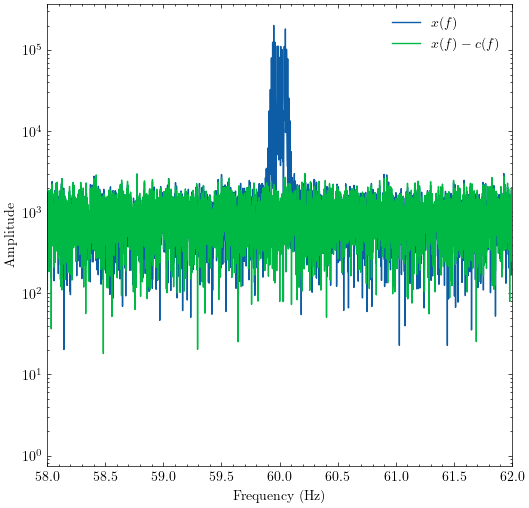

In [7]:
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use('science')

dt = time[1]-time[0]
fs = 1/dt

fig_dimension = 6
fig, ax = plt.subplots(figsize=(fig_dimension, fig_dimension))
labels = [r'$x(f)$',r'$x(f) - c(f)$']
for i, s in enumerate([x, c_RLS]):
    fft_result = np.fft.fft(s)
    N = len(s)
    freq = np.fft.fftfreq(N, d=dt)

    # Get the magnitude spectrum (absolute value)
    magnitude_spectrum = np.abs(fft_result)

    # If you want the power spectrum
    power_spectrum = np.abs(fft_result)**2

    # Note: The FFT is symmetric for real signals, so often you only want the positive frequencies
    # You can get these by:
    positive_freq = freq[:N//2]
    positive_magnitude = magnitude_spectrum[:N//2]

    ax.plot(positive_freq, positive_magnitude,label = labels[i])



plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(58,62)
plt.legend()
plt.yscale('log')
